In [ ]:
from google.colab import files
import numpy as np
from numpy.random import randint, rand
import pandas as pd
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
                                                                ##### Plot #####
def plot_image(y,n):
  plt.figure(figsize=(20,1))
  plt.scatter(hnum[0],y)
  plt.plot(hnum[0],y)     
  plt.axis('off')
  plt.title(f"{n}")
  plt.show()

In [ ]:
files.upload()

In [ ]:
                           ##### dataset_full including inputs and outputs #####
xy=pd.read_csv("dataset_full60.csv")
## Split into x,y ##
y=np.array([xy["efficiency"],xy["stress"],xy["deformation"]]).T
X=xy.drop(columns=["efficiency","stress","deformation"])
## float64 --> 32 ##
X=np.array(X,dtype="float32")
y=y.astype(np.float32)
## Scale the y ##
scaler= MinMaxScaler()
scaled_y= scaler.fit_transform(y)
Y=np.array(scaled_y)

In [ ]:
                                                   ### RandomForestRegressor ###
cv=RepeatedKFold(n_splits=5, n_repeats=10, random_state=2)
forest=RandomForestRegressor()
forest_cross=cross_val_score(forest,X,Y,scoring="neg_mean_squared_error", cv=cv, n_jobs=-1)
final_forest=forest.fit(X,Y)

In [ ]:
# Upload x_dataset, y_dataset
files.upload()

In [ ]:
                            ##### dataset including only inputs (features) #####
v= pd.read_csv("y_dataset.csv")
h= pd.read_csv("x_dataset.csv")
vnum=v.to_numpy(dtype="float32")
hnum=h.to_numpy(dtype="float32")
## Split into train and test ##
train,test = train_test_split(vnum,test_size=0.2,random_state=42)

In [ ]:
                                                            ##### Sampling #####
class Sampling(keras.layers.Layer):
  def call(self,inputs):
      mean,log_var=inputs
      return keras.backend.random_normal(shape= tf.shape(log_var)) * keras.backend.exp(log_var/2) + mean

In [ ]:
# Upload saved weights
files.upload()

In [ ]:
codings_size=10
# Encoder
inputs=keras.layers.Input(shape=(200,))
z=keras.layers.Dense(150, activation=keras.layers.LeakyReLU(alpha=0.1))(inputs)
z=keras.layers.Dense(100, activation=keras.layers.LeakyReLU(alpha=0.1))(z)
codings_mean=keras.layers.Dense(codings_size)(z)
codings_log_var=keras.layers.Dense(codings_size)(z)
codings=Sampling()([codings_mean,codings_log_var])
encoder=keras.models.Model(inputs=[inputs],outputs=[codings])
# Decoder
decoder_inputs=keras.layers.Input(shape=[codings_size])
x=keras.layers.Dense(100,activation=keras.layers.LeakyReLU(alpha=0.1))(decoder_inputs)
x=keras.layers.Dense(150,activation=keras.layers.LeakyReLU(alpha=0.1))(x)
outputs=keras.layers.Dense(200,activation="tanh")(x)
decoder=keras.models.Model(inputs=[decoder_inputs],outputs=[outputs])

# VAE
codings=encoder(inputs)
reconstructions=decoder(codings)
vae=keras.models.Model(inputs=[inputs], outputs=[reconstructions])
# loss
latent_loss= -0.5* keras.backend.sum(1 + codings_log_var - keras.backend.exp(codings_log_var)- keras.backend.square(codings_mean), axis=-1)
vae.add_loss(keras.backend.mean(latent_loss)/200.)
optimizer=keras.optimizers.Adam(learning_rate=0.0005)
filepath="vae_5_70.h5"
vae.load_weights(filepath)
vae.compile(loss="mean_squared_error", optimizer=optimizer)

In [ ]:
                                                  ##### Objective function #####
def predictions(decoded):
    pre=final_forest.predict(decoded)            
    ## Invert scaled to real data ##
    prediction=scaler.inverse_transform(pre) 
    return prediction

In [ ]:
                                                     ##### Decode function #####
def decode(individual):
    return decoder(individual)

In [ ]:
                                                    ##### Fitness function #####
def fitness(p, efficiency_t):
  efficiency= predictions(decode(p))[0,0]
  fitness_score= (efficiency_t - efficiency) / efficiency_t
  return fitness_score

In [ ]:
																													##### tournament (Selection) #####
def selection(pop,efficiency_t,k=5):
		# first random selection
		selection_ix = randint(len(pop))
		for ix in randint(0, len(pop), k-1):
				p1=np.array(pop[selection_ix]).reshape(1,-1)
				fitnessscore1=fitness(p1, efficiency_t)
				p2=np.array(pop[ix]).reshape(1,-1)
				fitnessscore2=fitness(p2, efficiency_t)
				# check if better (e.g. perform a tournament)
				if fitnessscore2 <= fitnessscore1:
						selection_ix = ix
		return pop[selection_ix]

In [ ]:
                                                          ##### Population function #####
## real dataset ##
def real(n_pop,feature_domain):
  pop=list()
  for n in randint(0,70,n_pop):
    p=feature_domain[n]
    pop.append(p)
  return pop

####################

## interpolated dataset ##
def interpolate(n_pop,feature_domain):
  pop=list()
  for n in randint(0,70,n_pop):
    z1=feature_domain[n]
    m= randint(0,70)
    if m==n:
      m+=1
    z2=feature_domain[m]
    neu=rand()
    z3=neu*z1+(1-neu)*z2
    pop.append(z3)
  return pop

####################

# extrapolated dataset ##
def extrapolate(n_pop,feature_domain):
  pop=list()
  for n in randint(0,70,n_pop):
    z1=feature_domain[n]
    m= randint(0,70)
    if m==n:
      m+=1
    z2=feature_domain[m]
    neu=-rand()
    z3=neu*z1+(1-neu)*z2
    pop.append(z3)
  return pop

####################

## random dataset ##
def random(n_pop,codings_size):
  pop=[]
  noise=tf.random.normal(shape=[n_pop,codings_size])
  pop=np.array(noise)
  pop=pop.tolist()
  return pop

####################

## combined dataset ##
def combination(n_pop,feature_domain,codings_size):
  poop= (interpolate(int(n_pop/3),feature_domain)+ extrapolate(int(n_pop/3),feature_domain)+ random(int(n_pop/3),codings_size))
  return poop

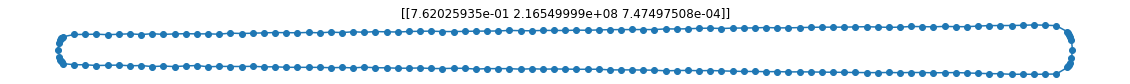

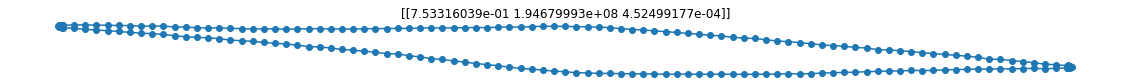

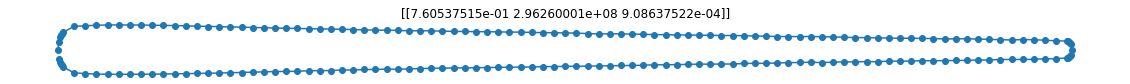

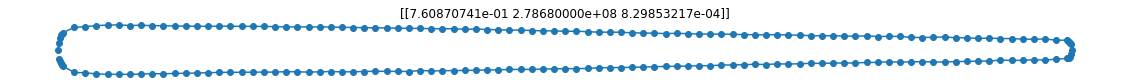

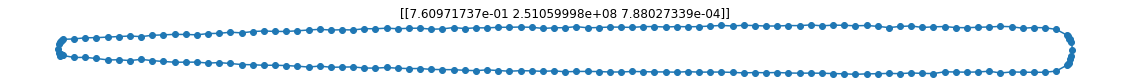

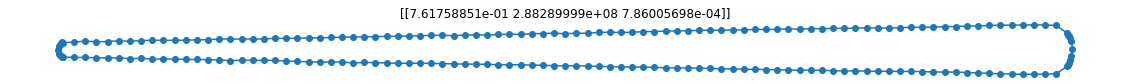

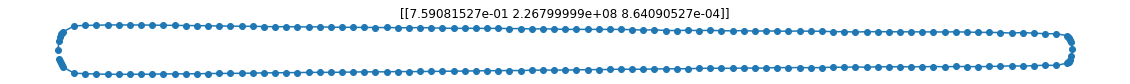

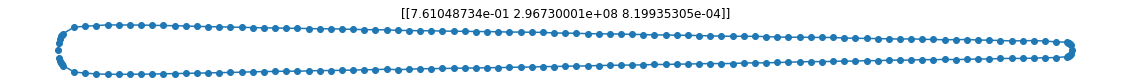

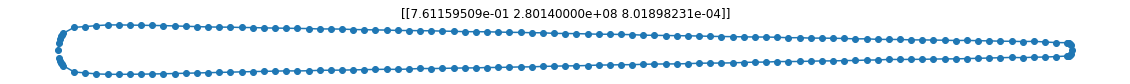

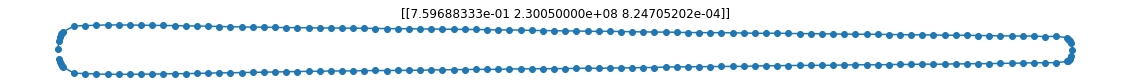

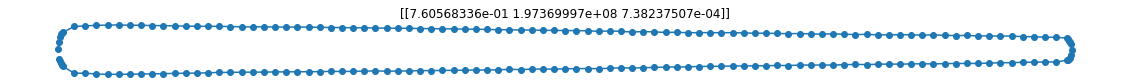

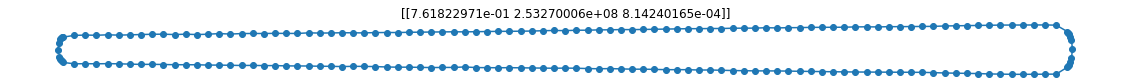

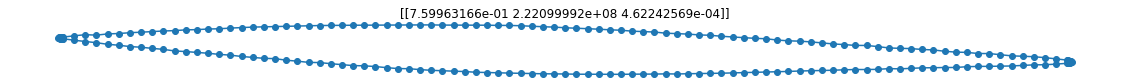

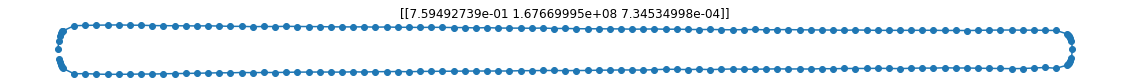

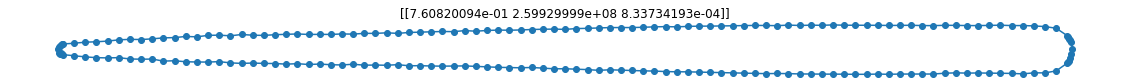

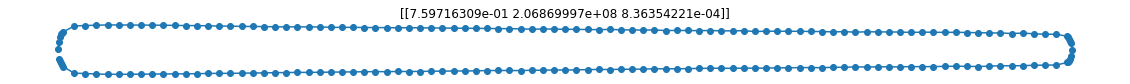

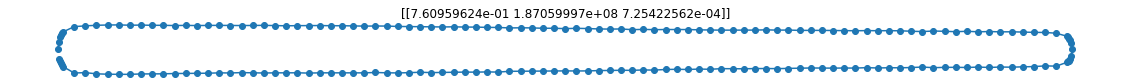

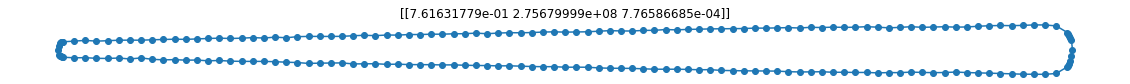

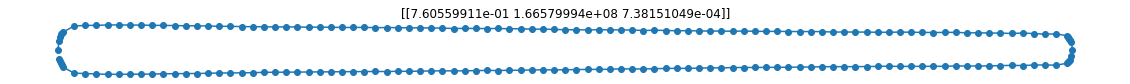

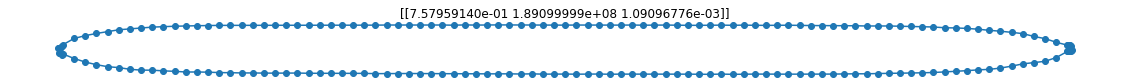

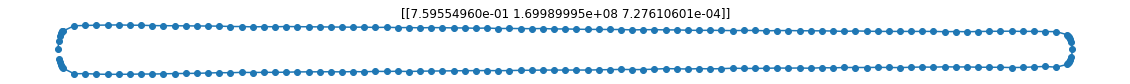

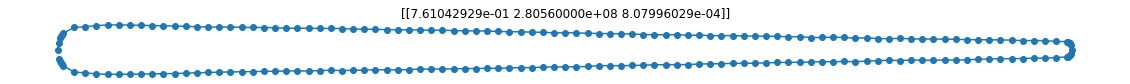

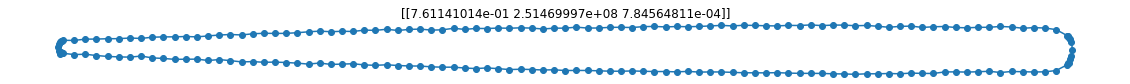

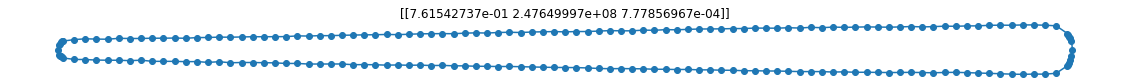

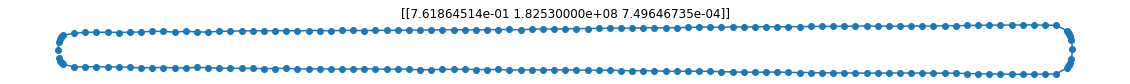

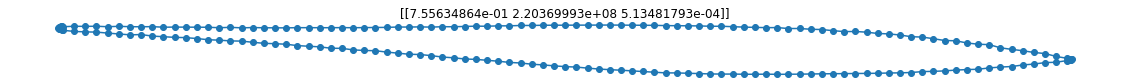

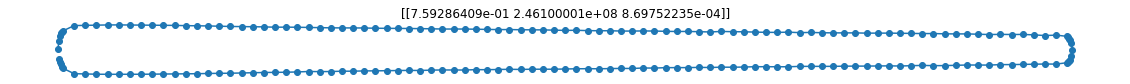

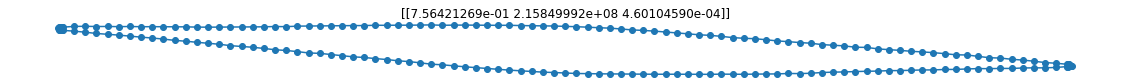

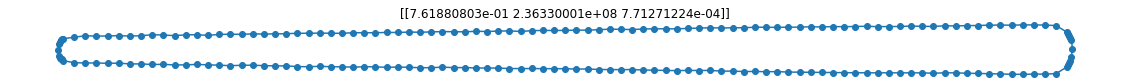

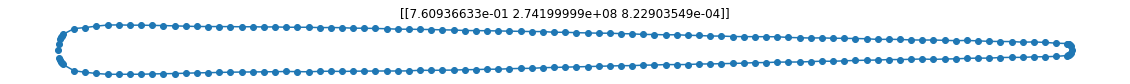

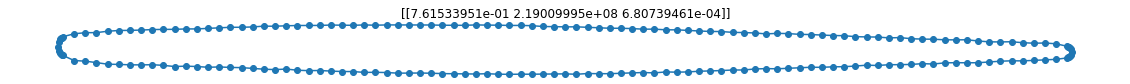

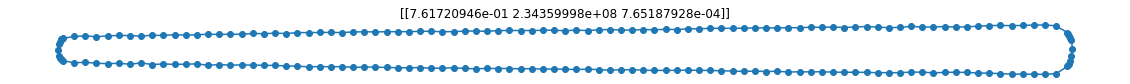

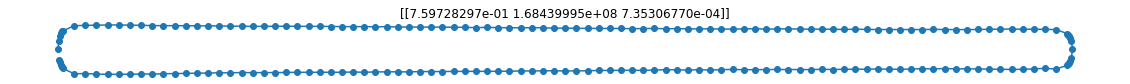

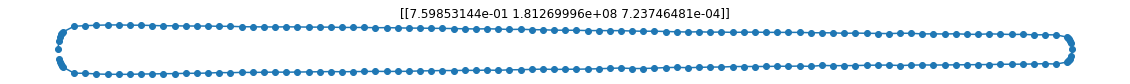

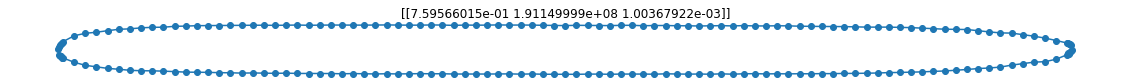

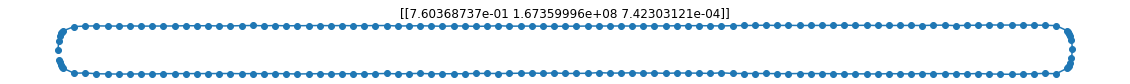

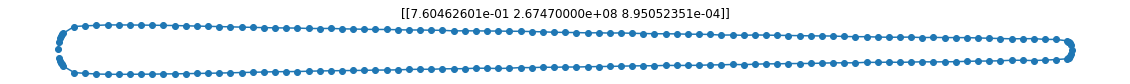

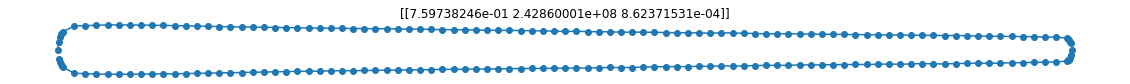

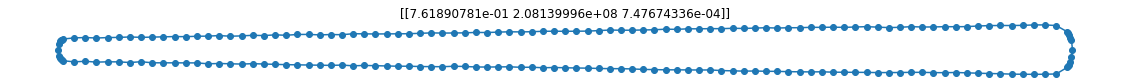

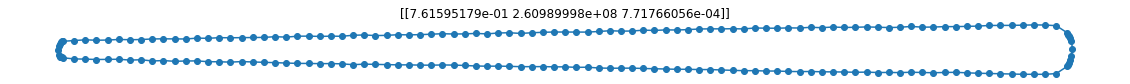

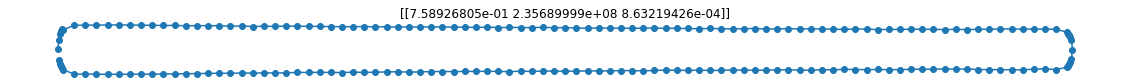

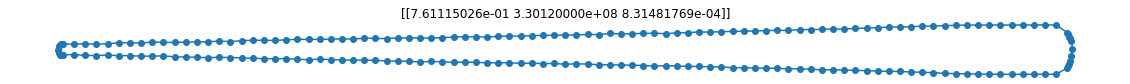

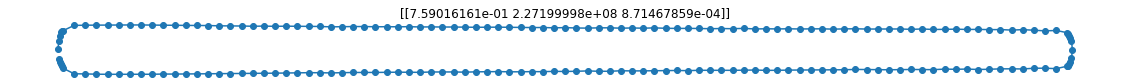

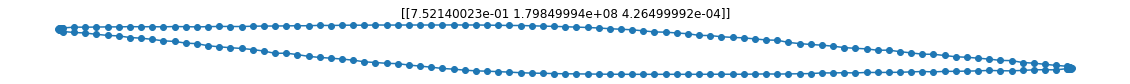

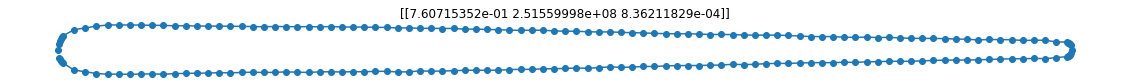

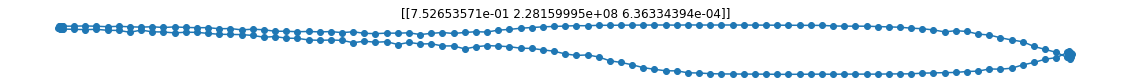

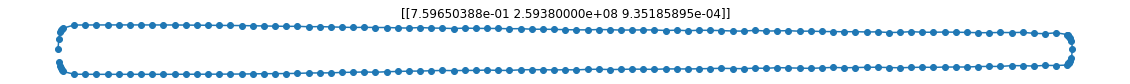

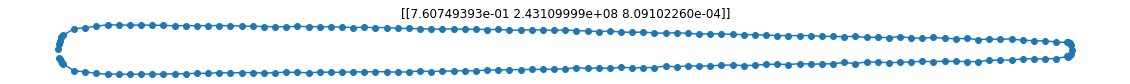

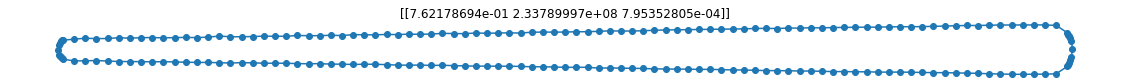

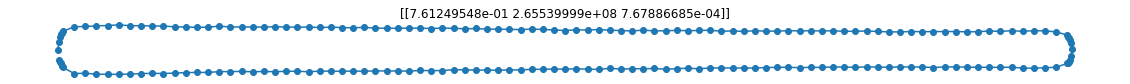

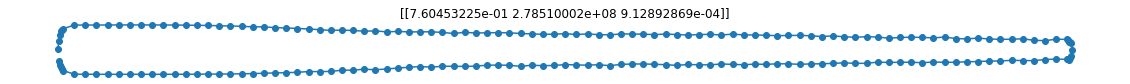

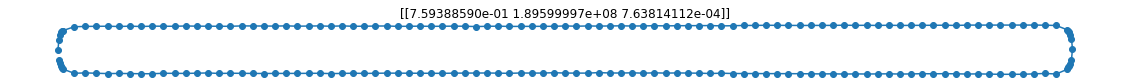

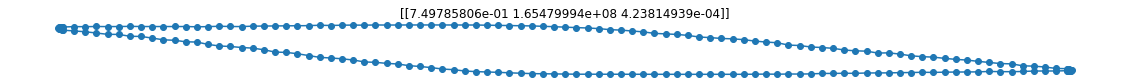

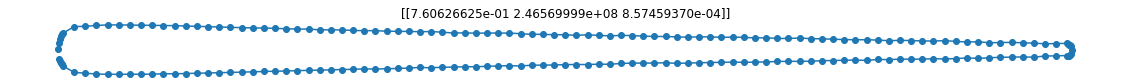

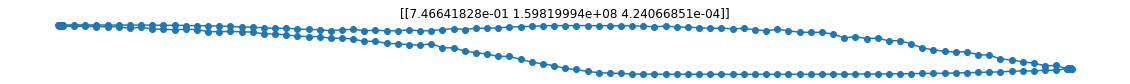

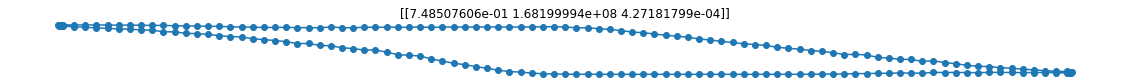

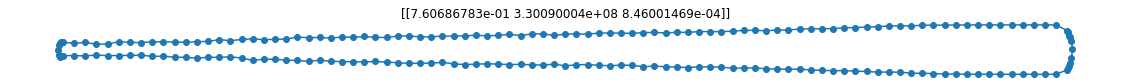

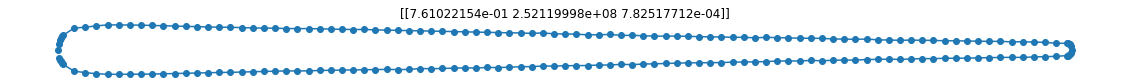

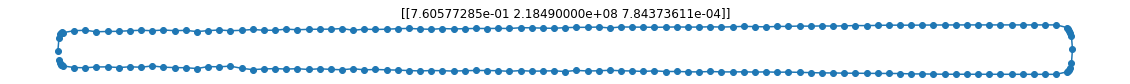

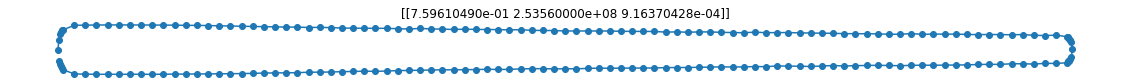

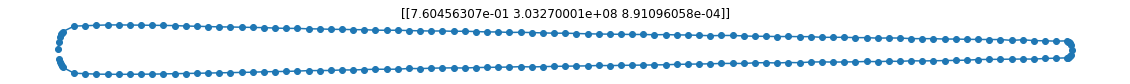

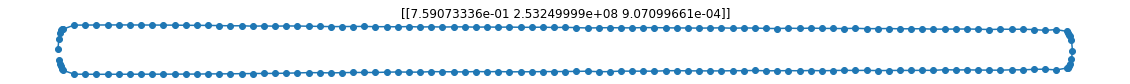

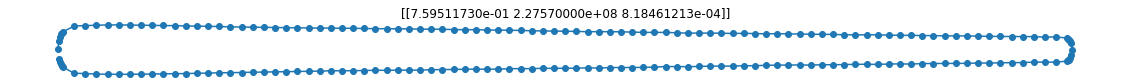

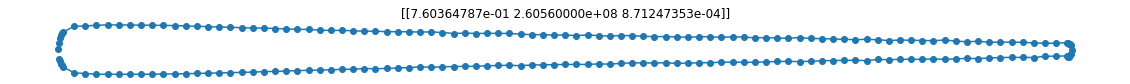

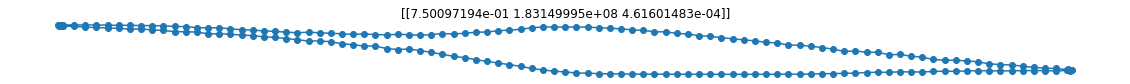

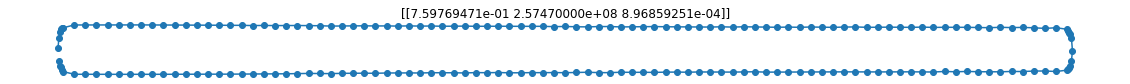

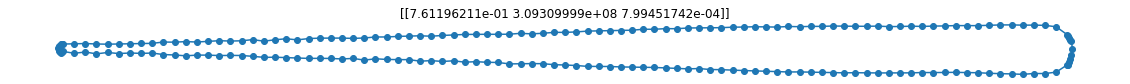

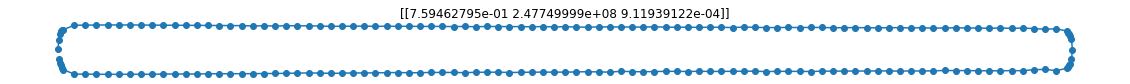

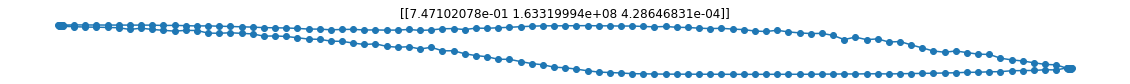

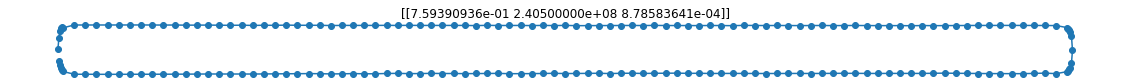

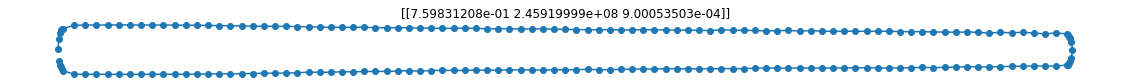

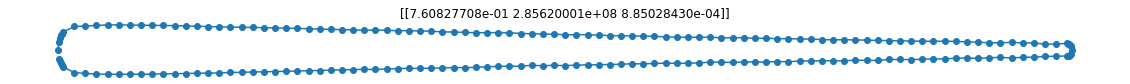

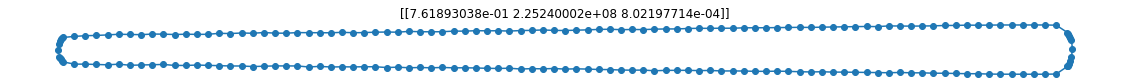

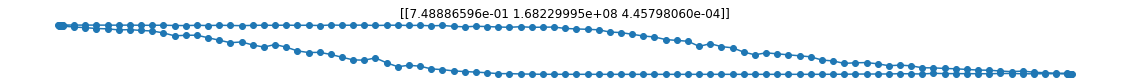

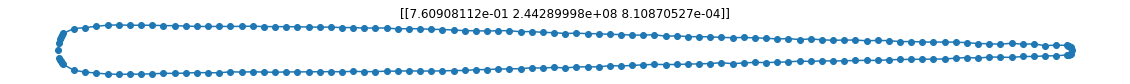

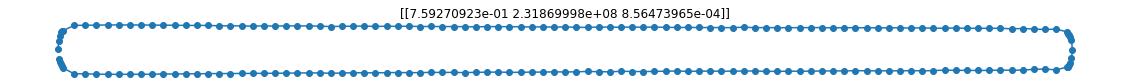

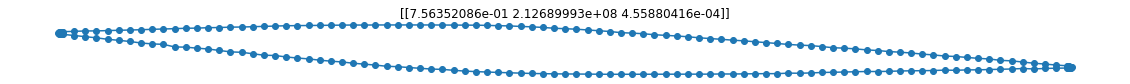

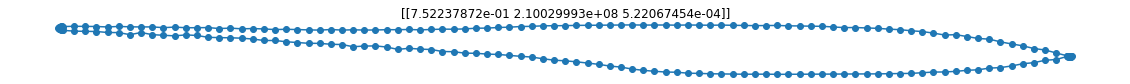

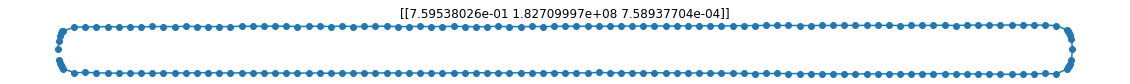

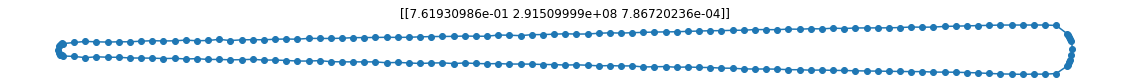

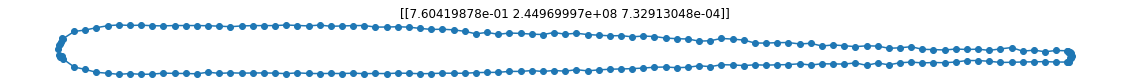

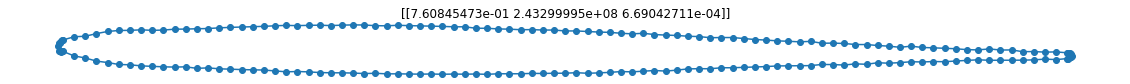

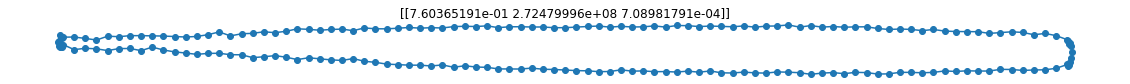

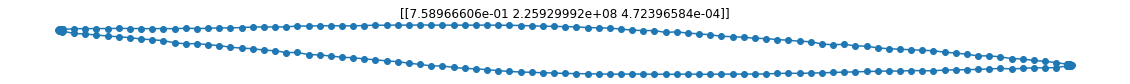

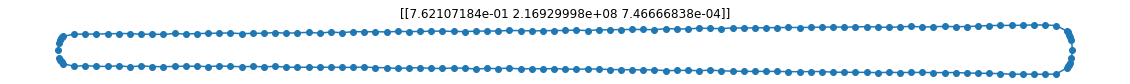

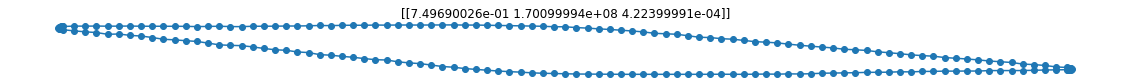

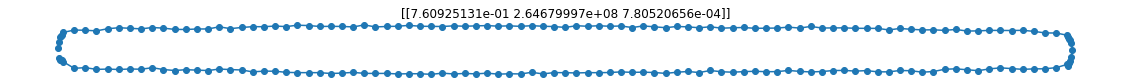

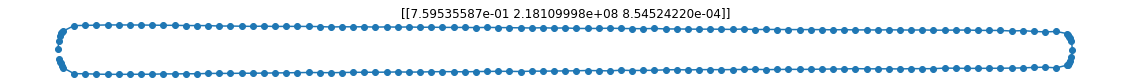

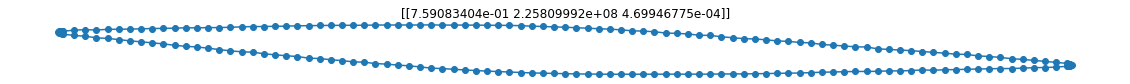

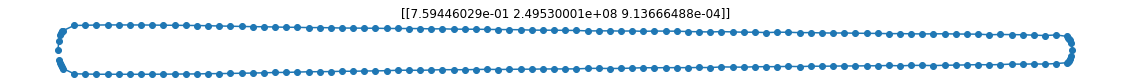

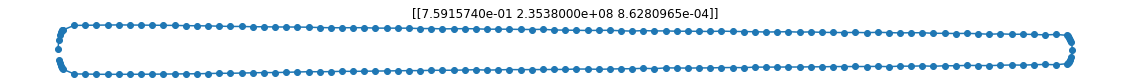

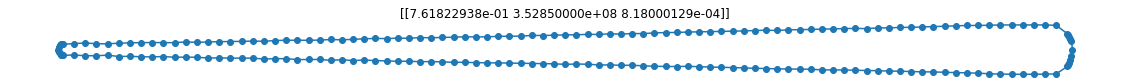

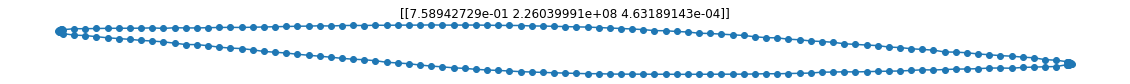

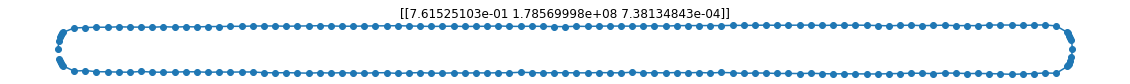

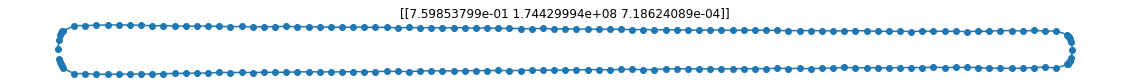

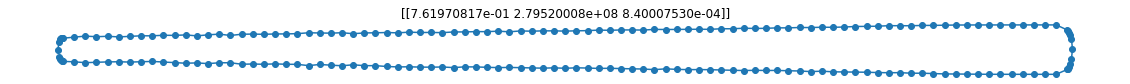

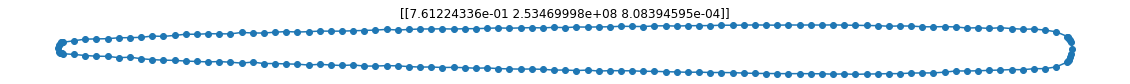

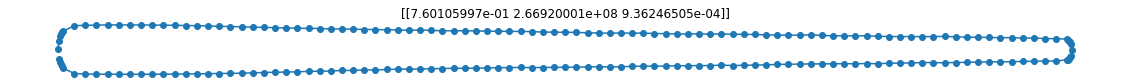

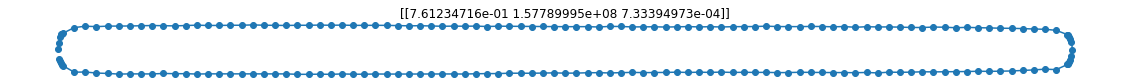

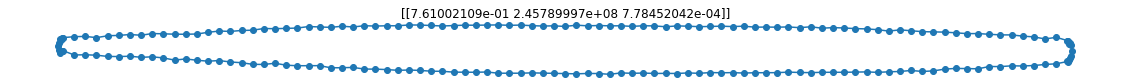

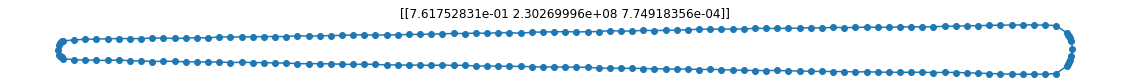

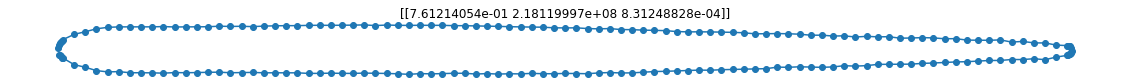

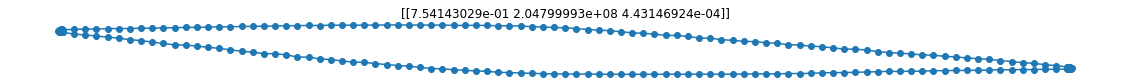

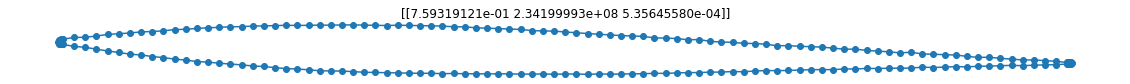

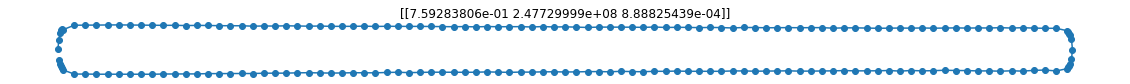

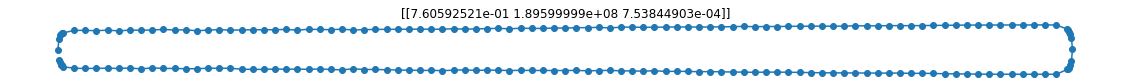

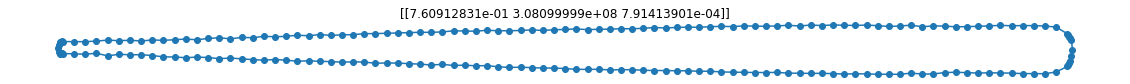

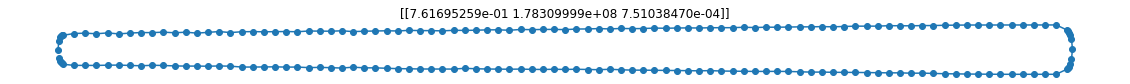

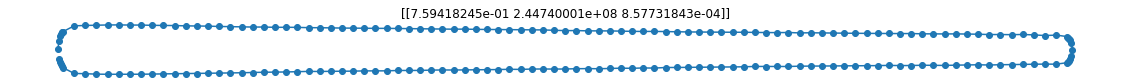

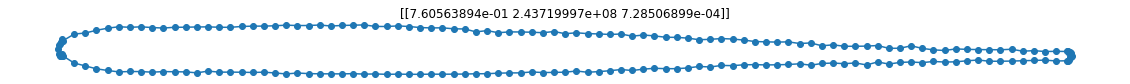

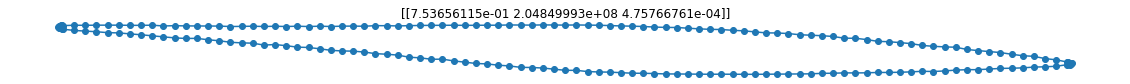

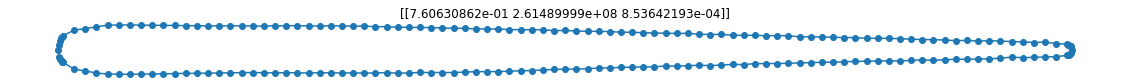

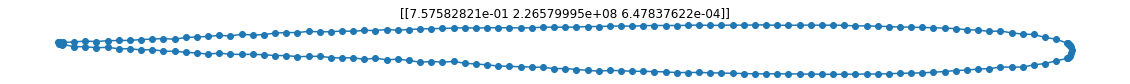

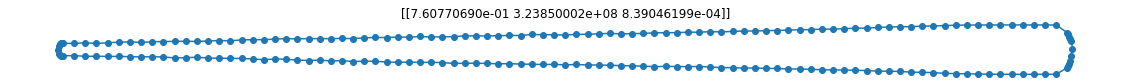

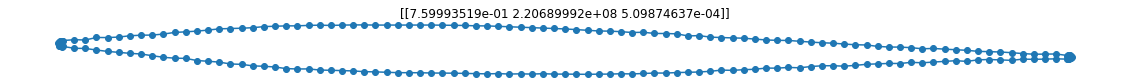

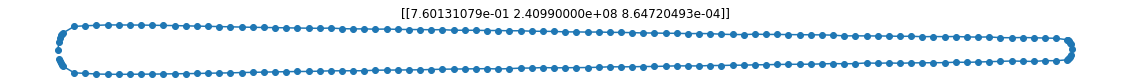

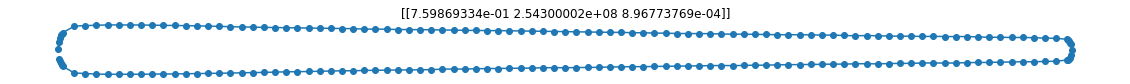

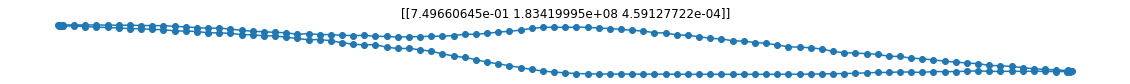

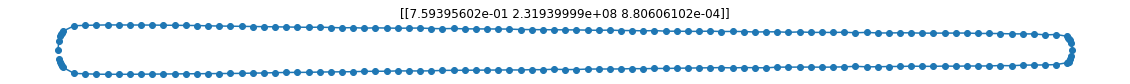

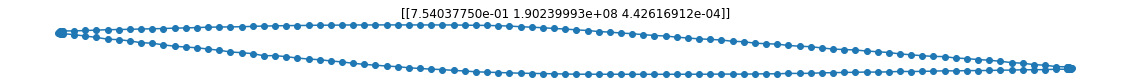

gen=  0
best0=  [[ 1.32258189 -1.00097024  1.85129929  0.3934446   1.76523733  0.97221875
  -0.1446775   1.32769883 -1.62730086 -0.52622646]] 
 best_prediction0=  [0.7540377499420281, 190239993.27402586, 0.00044261691172583177]


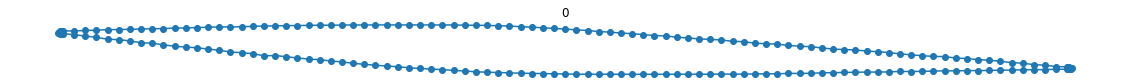

gen=  1
best1=  [[ 1.5821054  -0.00960779  1.41184497  1.88347685 -0.64644527  2.26002717
   1.13130999  0.23963201 -0.35820198  2.0068686 ]] 
 best_prediction1=  [0.7510900254437647, 180599993.71788523, 0.0004238999903308445]


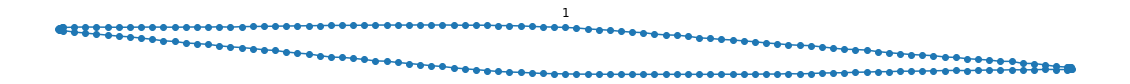

gen=  2
best2=  [[ 1.5343042  -0.96141535  2.6811645   0.57241359  1.24367878  0.33023572
   1.63214153  0.75253236 -0.28960764  3.76187468]] 
 best_prediction2=  [0.7514000235081733, 175349993.64712796, 0.00042229998925416806]


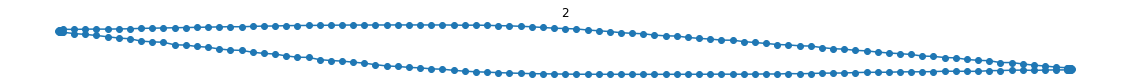

gen=  3
best3=  [[ 2.36633646 -1.75346982  0.09728658  1.54503012  1.64644527  2.26002717
   1.13130999  0.76036799 -0.35820198 -1.0068686 ]] 
 best_prediction3=  [0.7486158077772447, 163129994.55603248, 0.0004204149369288742]


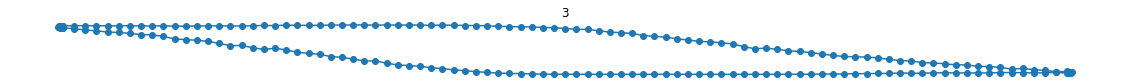

gen=  4
best4=  [[ 2.36633646 -1.75346982  0.09728658  1.54503012  1.64644527  2.26002717
   1.13130999  0.76036799 -0.35820198 -1.0068686 ]] 
 best_prediction4=  [0.7486158077772447, 163129994.55603248, 0.0004204149369288742]


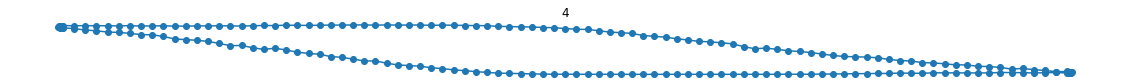

gen=  5
best5=  [[ 1.72466284  0.48517123  1.67720264 -2.19095588 -0.67168939 -1.31741965
  -0.01629099  1.51023746  0.79049993  0.07250845]] 
 best_prediction5=  [0.7496000248816127, 175099994.01577666, 0.0004255999925835393]


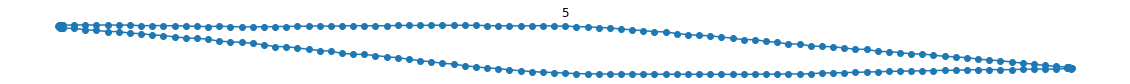

gen=  6
best6=  [[ 1.72466284  0.48517123  1.67720264  1.21900432  0.65072507  0.52292943
   0.5056383   2.29818761  2.35300875 -0.35417175]] 
 best_prediction6=  [0.7491000258398263, 167749994.13117397, 0.0004246999923474841]


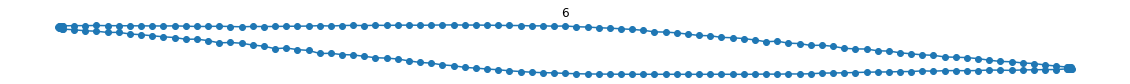

gen=  7
best7=  [[ 1.5821054   0.31143409  1.12796761 -1.14183629  0.30782127  0.36247981
  -1.79034424  1.62647069 -1.60941601  0.09767079]] 
 best_prediction7=  [0.7518500229651855, 181849993.55966485, 0.00042769999288795114]


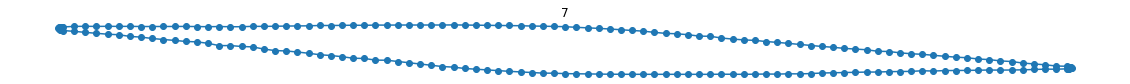

gen=  8
best8=  [[ 1.72466284  0.48517123  2.53480697 -0.89487725  0.30790609  0.97690994
   2.30562055  1.56262994 -0.86402678  1.99550509]] 
 best_prediction8=  [0.749240024836896, 171599994.12178907, 0.00042439999214560726]


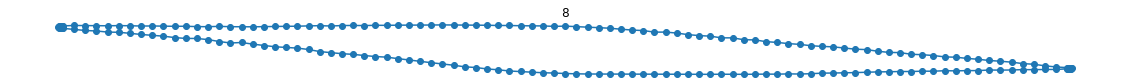

gen=  9
best9=  [[ 1.72466284 -0.62903142  2.53480697 -0.89487725  0.30790609  0.02309006
  -0.44762623  0.91894364  0.50213045  0.54482764]] 
 best_prediction9=  [0.7492658079688874, 168979994.3547685, 0.00042281493780473825]


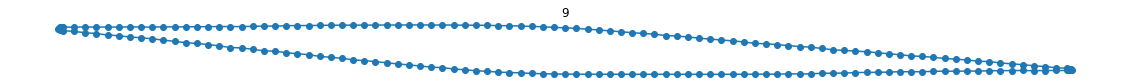

gen=  10
best10=  [[ 0.92873129 -0.4751718  -0.5396837  -1.14183629  1.64644527  0.01044728
   1.87037307  0.75253236  1.28960764 -2.76187468]] 
 best_prediction10=  [0.7599586786362449, 226559991.60013676, 0.0004624938329405136]


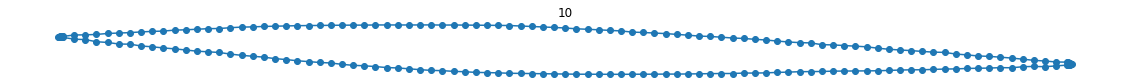

gen=  11
best11=  [[ 1.72466284 -0.61772108  1.67720264  0.6471892   1.64644527  0.54346311
   1.87037307  0.24746764 -0.28960764  3.76187468]] 
 best_prediction11=  [0.7493858066529407, 168229994.3118352, 0.0004236149387126518]


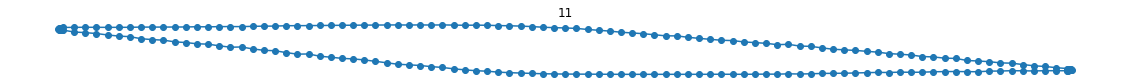

gen=  12
best12=  [[ 1.72466284 -0.61772108  1.67720264  0.6471892   1.64644527  0.54346311
   1.87037307  0.24746764 -0.28960764  3.76187468]] 
 best_prediction12=  [0.7493858066529407, 168229994.3118352, 0.0004236149387126518]


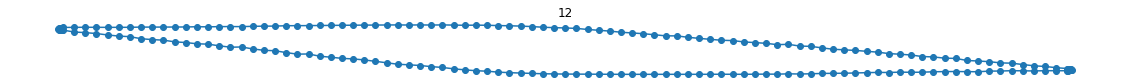

gen=  13
best13=  [[ 1.72466284 -0.61772108 -1.66115808 -0.05522871  1.18629111  0.01044728
   0.78867908  0.91894364  0.49786955  0.54482764]] 
 best_prediction13=  [0.749555806518791, 166129994.34480584, 0.00042371493877994414]


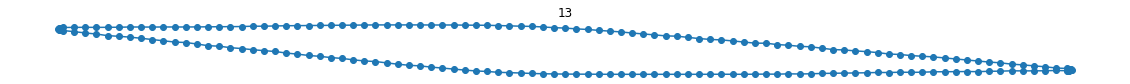

gen=  14
best14=  [[ 1.72466284  0.51482877  1.67720264 -1.14183629  0.30782127  0.45653689
   1.87037307  0.91894364  0.50213045  0.54482764]] 
 best_prediction14=  [0.7494700264403068, 173249994.06305844, 0.00042339999110310917]


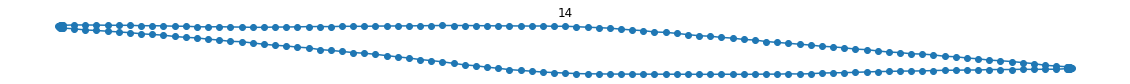

gen=  15
best15=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction15=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


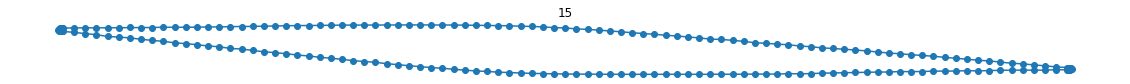

gen=  16
best16=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction16=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


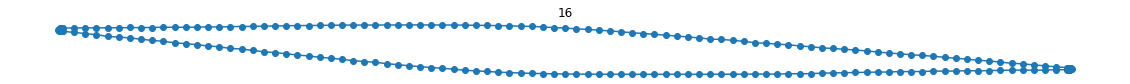

gen=  17
best17=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction17=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


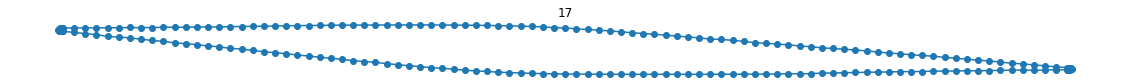

gen=  18
best18=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction18=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


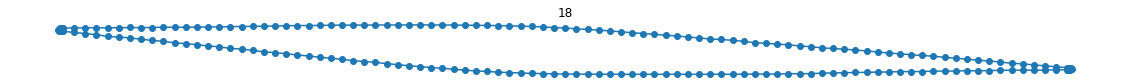

gen=  19
best19=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction19=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


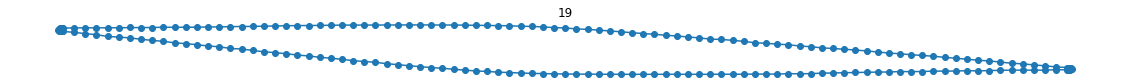

gen=  20
best20=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction20=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


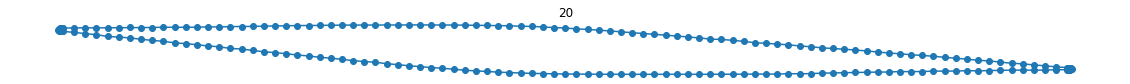

gen=  21
best21=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction21=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


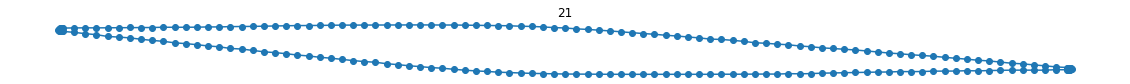

gen=  22
best22=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction22=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


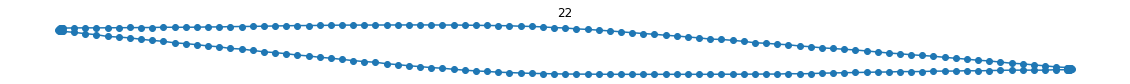

gen=  23
best23=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction23=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


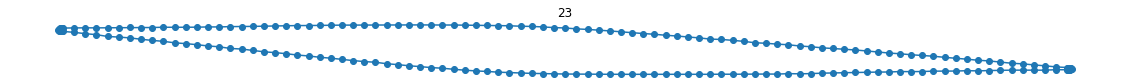

gen=  24
best24=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction24=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


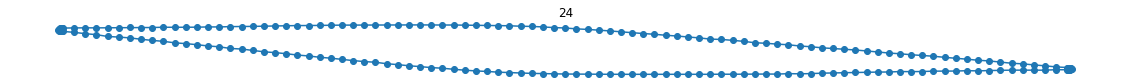

gen=  25
best25=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction25=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


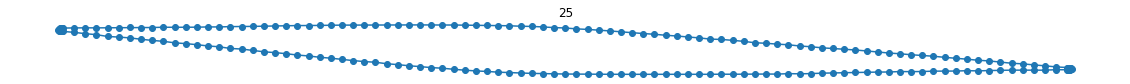

gen=  26
best26=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction26=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


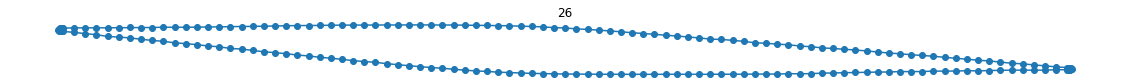

gen=  27
best27=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction27=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


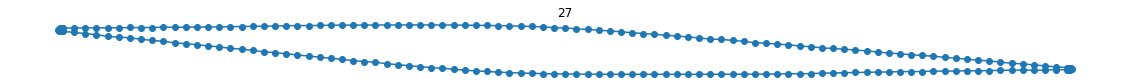

gen=  28
best28=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction28=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


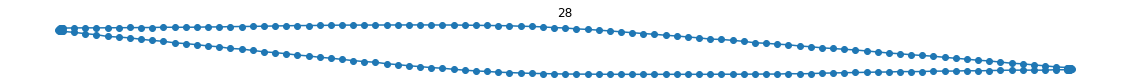

gen=  29
best29=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction29=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


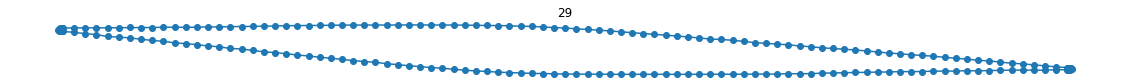

gen=  30
best30=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction30=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


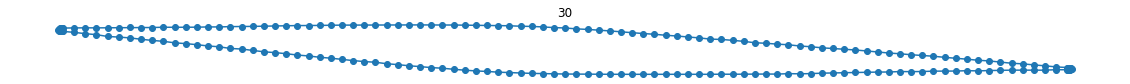

gen=  31
best31=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction31=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


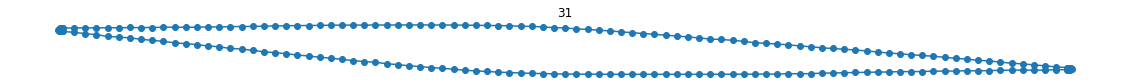

gen=  32
best32=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction32=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


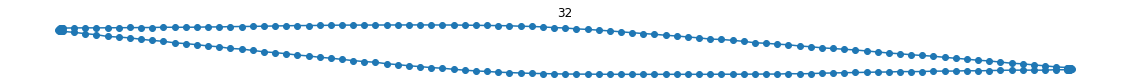

gen=  33
best33=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction33=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


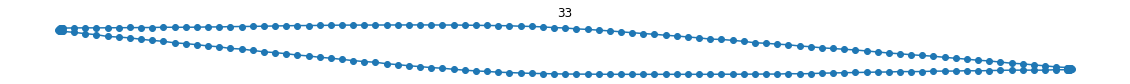

gen=  34
best34=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction34=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


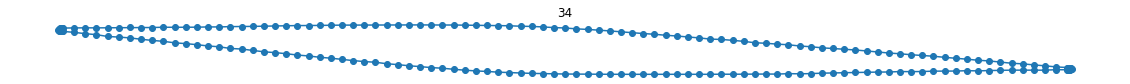

gen=  35
best35=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction35=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


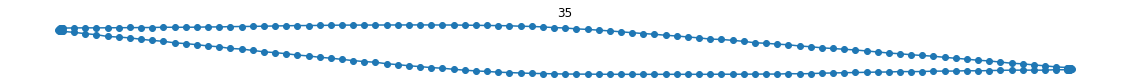

gen=  36
best36=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction36=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


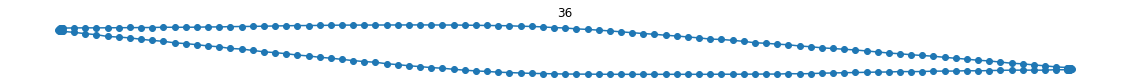

gen=  37
best37=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction37=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


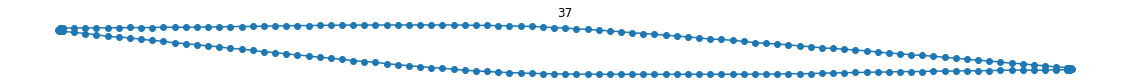

gen=  38
best38=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction38=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


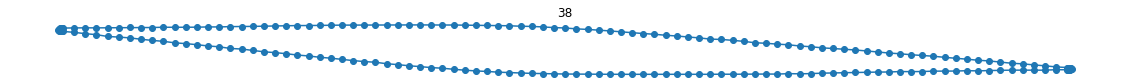

gen=  39
best39=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction39=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


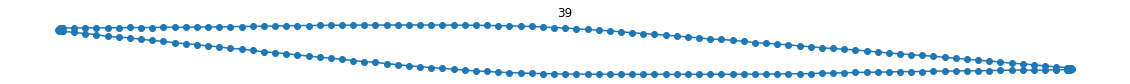

gen=  40
best40=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction40=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


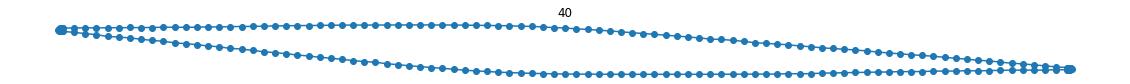

gen=  41
best41=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction41=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


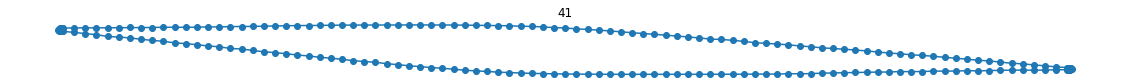

gen=  42
best42=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction42=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


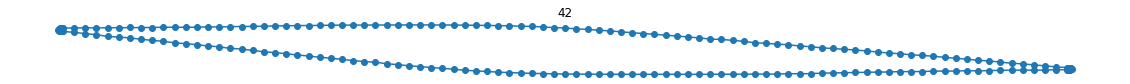

gen=  43
best43=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction43=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


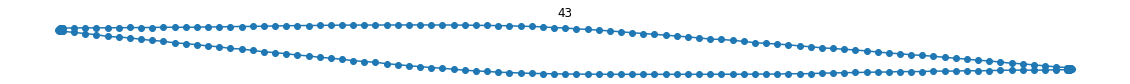

gen=  44
best44=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction44=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


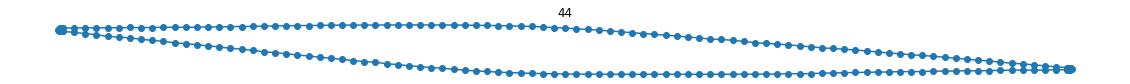

gen=  45
best45=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction45=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


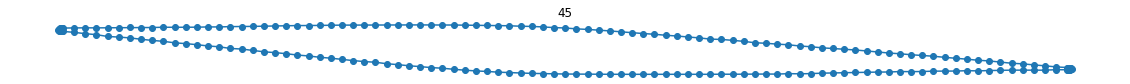

gen=  46
best46=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction46=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


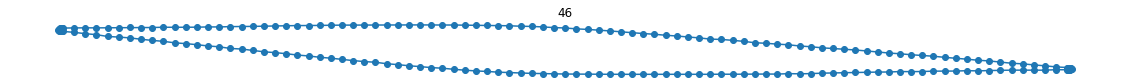

gen=  47
best47=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction47=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


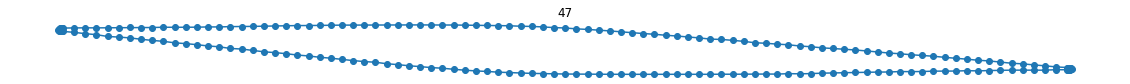

gen=  48
best48=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction48=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


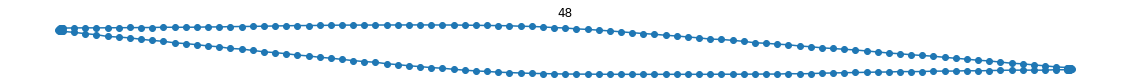

gen=  49
best49=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction49=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


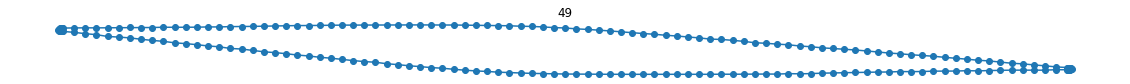

gen=  50
best50=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction50=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


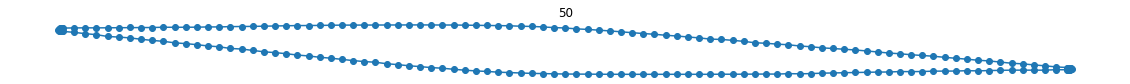

gen=  51
best51=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction51=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


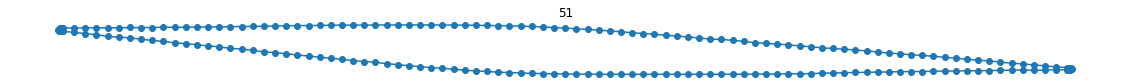

gen=  52
best52=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction52=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


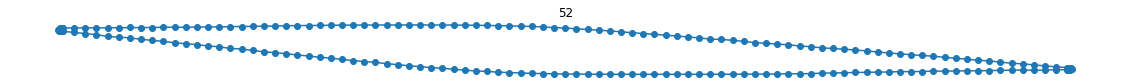

gen=  53
best53=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction53=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


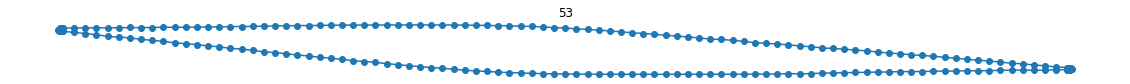

gen=  54
best54=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction54=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


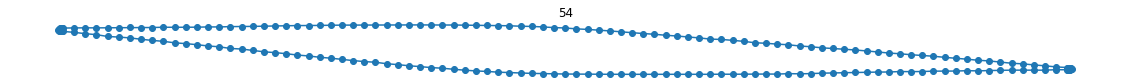

gen=  55
best55=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction55=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


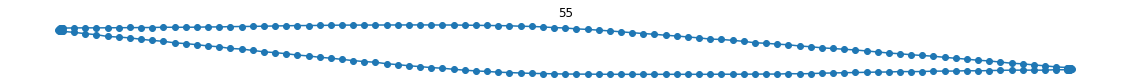

gen=  56
best56=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction56=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


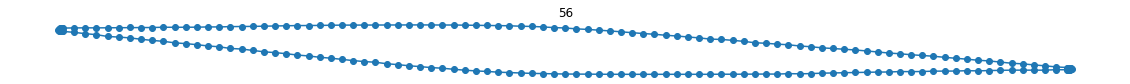

gen=  57
best57=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction57=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


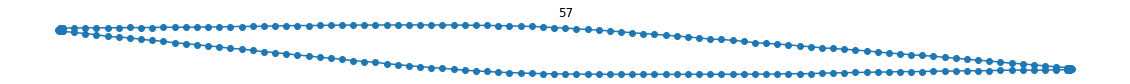

gen=  58
best58=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction58=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


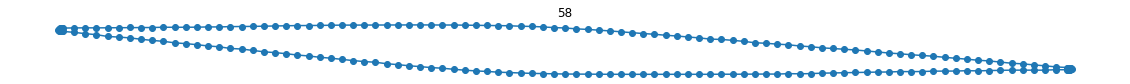

gen=  59
best59=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction59=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


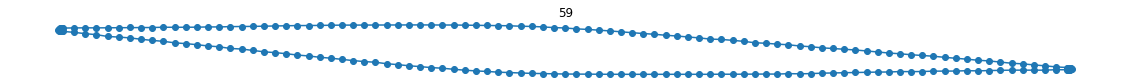

best59=  [[ 1.5821054  -0.61772108  0.19684118 -1.14183629  1.18629111 -0.08392692
   0.98607966  0.76036799  1.35820198 -1.0068686 ]] 
 best_prediction59=  [0.7497100270024588, 168249993.93002024, 0.000418699987940372]


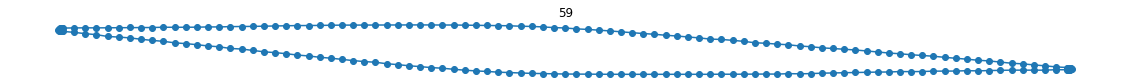

In [ ]:

n_generations=60
n_pop=120
r_cross=0.8
r_mut=0.7

efficiency_gen=[]
stress_gen=[]
deformation_gen=[]
## Initial population ##
feature_domain=encoder(vnum)
pop= combination(n_pop,feature_domain,codings_size)
for n in range(len(pop)):
  pp=np.array(pop[n]).reshape(1,-1)
  initialpop=decoder(pp)
  initialpop=tf.reshape(initialpop,[200])
  m=predictions(decode(pp))
  plot_image(initialpop,n=m)
## keep track of the best solution ##
p=np.array(pop[0]).reshape(1,-1)
best= p
best_efficiency=predictions(decode(best))[0,0]
best_stress= predictions(decode(best))[0,1]
best_deformation= predictions(decode(best))[0,2]
## enumerate generations
for gen in range(n_generations):
  print("gen= ",gen)
  for i in range(n_pop):
    p=np.array(pop[i]).reshape(1,-1)
    decoded=decode(p)
    prediction= predictions(decoded)
    efficiency=prediction[0,0]
    stress=prediction[0,1]
    deformation=prediction[0,2]
## check for new best solution 
    if efficiency >= best_efficiency and stress <= best_stress or deformation <= best_deformation:
      best= p
      best_efficiency= efficiency
      best_stress= stress
      best_deformation= deformation
## select parents 
  parents=list()
  for n in range(n_pop):
    parents.append(selection(pop,0.77,k=5))
## create the next generation 
  children = list()
  for i in range(0, n_pop, 2):
    p1, p2 = parents[i], parents[i+1]
    c1, c2 = np.copy(p1), np.copy(p2)
    p1, p2=np.array(p1), np.array(p2)
    p1, p2=p1.tolist(), p2.tolist()
## Crossover and Mutation
    if rand() < r_cross:
      pt = randint(1, len(p1)-2)
      c1 = p1[:pt] + p2[pt:]
      c2 = p2[:pt] + p1[pt:]
    for c in [c1,c2]:
      c=np.array(c)
      for i in range(len(c)):
        if rand() < r_mut:
          c[i] = 1 - c[i]
      c=c.tolist()
      children.append(c)
## Replace population
  pop = children
  print(f"best{gen}= ",best,"\n" , f"best_prediction{gen}= ",[best_efficiency,best_stress,best_deformation])
  efficiency_gen.append(best_efficiency)
  stress_gen.append(best_stress)
  deformation_gen.append(best_deformation)
  y=decoder(best)
  y=tf.reshape(y,[200])
  n=gen
  plot_image(y,n)

print(f"best{gen}= ",best,"\n" ,f"best_prediction{gen}= ",[best_efficiency,best_stress,best_deformation])
plot_image(y,n)

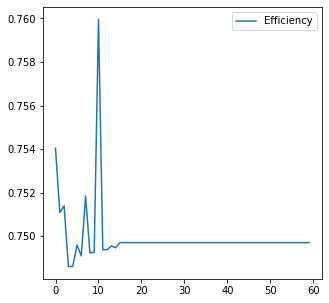

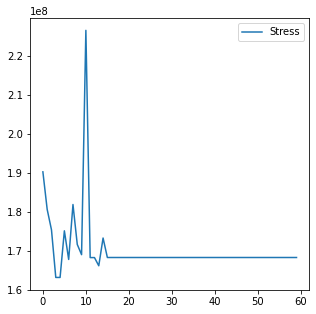

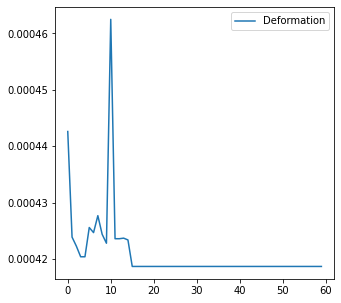

In [ ]:
x_axis=np.arange(n_generations)
plt.figure(figsize=(5,5))
plt.plot(x_axis,efficiency_gen, label="Efficiency")
plt.legend()

plt.figure(figsize=(5,5))
plt.plot(x_axis,stress_gen, label="Stress")
plt.legend()

plt.figure(figsize=(5,5))
plt.plot(x_axis,deformation_gen, label="Deformation")
plt.legend()